<div align="center">

## Deconvolution Layer
</div>

**The information concentrated through the Convolution Layer may lose too much information of the original data.
<br>
The results of image classification and object detection that depend on these lost information become unreliable.**

- **learning goal**
    - **To learn about Auto Encoder which replays the result of Convolution and restores information as similar as the original image.**

- **index**
    - **Package import and MNIST Dataset loading**
    - **AutoEncoder model configuration**
    - **AutoEncoder model training**
    - **AutoEncoder Reconstruction Test**

In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import json
import matplotlib.pyplot as plt #for plotting

# MNIST data load
(x_train, _), (x_test, _) = mnist.load_data()    

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

11501568/11490434 [==============================] - 0s 0us/step


**: Image Reconstruction Task performed by AutoEncoder does not use y_train, y_test because the label of x_train becomes x_train itself.**

In [14]:
# AutoEncoder model configuration - Input area
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder model configuration - Encoder area
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
encode_pool_layer_1 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
encode_pool_layer_2 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu', padding='same')
encode_pool_layer_3 = MaxPooling2D((2, 2), padding='same')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)
encoded = encode_pool_layer_3(encoded)

# AutoEncoder model configuration - Decoder area
decode_conv_layer_1 = Conv2D(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder model definition
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 4)           0   

**What's important here is that the Conv2D layer does not change the shape. Changing the Output shape is the role of the MaxPooling2D layer.**
<br>

**So the Output right after passing through the Encoder is a shape of 4 X 4.
The concern we are looking at now is this Decorder layer.**
<br>

**I will re-examine the details below. The output of 28 X 28 size finally comes through the Conv2D layer and the UpSampling2D layer.UpSampling2D is the only thing that changes the shape here.**

In [21]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 6s 9ms/step - loss: 0.6955 - val_loss: 0.6951
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6946 - val_loss: 0.6941
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6936 - val_loss: 0.6930
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6923 - val_loss: 0.6916
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6907 - val_loss: 0.6897
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6884 - val_loss: 0.6868
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6846 - val_loss: 0.6822
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6788 - val_loss: 0.6750
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6697 - val_loss: 0.6637
Epoch 10/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6545 - val_loss: 0.6436

**: This loss is valid only with binary_crossentropy, as it is hoped that the distribution between input data with values between 0 and 1 in all dims and output data (note that the last output is controlled by sigmoid) will be as similar as possible.**

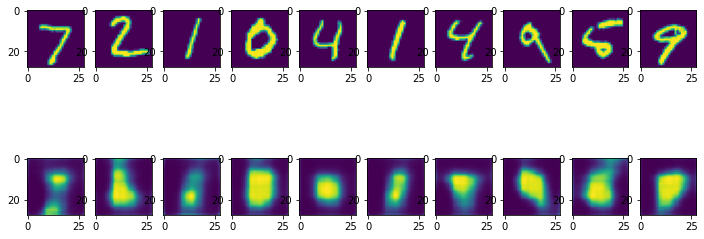

In [22]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])

**Upsampling Layer**

**: If tried Downsampling through Max pooling layer, it will now perform the opposite work through Upsampling layer.**

- Nearest Neighbor: Replicate the value to be restored to a close value.
- Bed of Nails: Process the value to be restored to zero.
- Max Unpooling: Restore the value discarded at Max Pooling and then restore it to that value.
- [reference](https://analysisbugs.tistory.com/104)

**Transposed Convolution**

- [Up-sampling with Transposed Convolution](https://zzsza.github.io/data/2018/06/25/upsampling-with-transposed-convolution/)

- Transposed Convolution was not utilized above; if it was utilized, the model structure would be as follows:

In [2]:
from tensorflow.keras.layers import Conv2DTranspose

# Conv2DTranspose를 활용한  AutoEncoder 모델
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu')
encode_pool_layer_1 = MaxPooling2D((2, 2))
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu')
encode_pool_layer_2 = MaxPooling2D((2, 2))
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분  - 
decode_conv_layer_1 = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2DTranspose(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 4)           292       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 4)           148   

In [3]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 30s 9ms/step - loss: 0.6935 - val_loss: 0.6931
Epoch 2/50
235/235 [==============================] - 2s 6ms/step - loss: 0.6927 - val_loss: 0.6922
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6917 - val_loss: 0.6912
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6906 - val_loss: 0.6899
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6892 - val_loss: 0.6883
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6873 - val_loss: 0.6862
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6848 - val_loss: 0.6832
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6811 - val_loss: 0.6788
Epoch 9/50
235/235 [==============================] - 2s 6ms/step - loss: 0.6757 - val_loss: 0.6722
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6674 - val_loss: 0.662

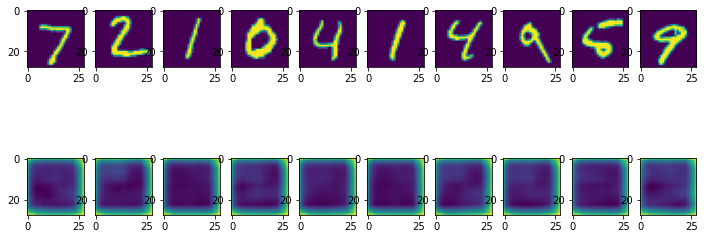

In [4]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])